# Assignment 3 Primer

* Assignment 3 will be based on a sample of movie rating predictions from the Netflix Prize dataset.
* It includes two pregenerated splits of 10k users for about 3k movies. So there is already a train and validation split that you will use for your experiments.
* It can be a little tricky to use predefined splits in surpise, so I will show you how to do it here.
* There are many articles available that talk about the million dollar prize and what it meant for the company. A few are:
* https://towardsdatascience.com/deep-dive-into-netflixs-recommender-system-341806ae3b48
* https://www.thrillist.com/entertainment/nation/the-netflix-prize
* https://analyticsindiamag.com/how-useful-was-the-netflix-prize-really/

In [1]:
import numpy as np
import pyarrow.feather as feather
import pandas as pd

# If you are on an Intel-based machine, you can also enable scikit-learn intel optimizations.
# This does not work on an M1 / M2 Macbook, but does on older Macbooks with an Intel.
# Requires ``pip install scikit-learn-intelex''
#
# from sklearnex import patch_sklearn
# patch_sklearn()

In [346]:
import pyarrow.feather as feather
import pandas as pd
from surprise import Dataset, Reader, BaselineOnly, accuracy
from surprise.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from joblib import parallel_backend
import os, psutil
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import CoClustering
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
import heapq
from collections import defaultdict
from operator import itemgetter
from sklearn.model_selection import ParameterGrid
import random
from matplotlib import pyplot
import seaborn as sns
from tabulate import tabulate


In [3]:
df_train = feather.read_feather('netflix-5k.train.feather')
df_val = feather.read_feather('netflix-5k.validation.feather')
df_titles = feather.read_feather('netflix-5k.movie_titles.feather')

In [4]:
display(df_titles)

,movieID,imdb_id,imdb_date,date,title,genre
0,3,1860,1997,1997,Character,Drama
1,8,27899,2004,2004,What the #$*! Do We Know!?,Comedy|Documentary|Drama
2,16,76,1995,1996,Screamers,Action|Sci-Fi|Thriller
3,18,249,1994,1994,Immortal Beloved,Drama|Romance
4,26,7368,2004,2004,Never Die Alone,Crime|Drama|Thriller
...,...,...,...,...,...,...
4329,17761,6285,2003,2003,Levity,Drama
4330,17762,1653,1997,1997,Gattaca,Drama|Sci-Fi|Thriller
4331,17763,3813,1978,1978,Interiors,Drama
4332,17764,2396,1998,1998,Shakespeare in Love,Comedy|Drama|Romance


In [5]:
display(df_train)

,userID,movieID,rating
0,1000596,10036,4.0
1,1000596,10100,2.0
2,1000596,10209,3.0
3,1000596,10212,3.0
4,1000596,10225,3.0
...,...,...,...
1287012,99993,9683,4.0
1287013,99993,9685,4.0
1287014,99993,9800,2.0
1287015,99993,9939,5.0


In [6]:
display(df_val)

,userID,movieID,rating
0,1000596,10827,4.0
1,1000596,11089,4.0
2,1000596,11279,3.0
3,1000596,11337,3.0
4,1000596,1180,3.0
...,...,...,...
321485,99993,8764,5.0
321486,99993,9092,4.0
321487,99993,9508,4.0
321488,99993,9788,3.0


In [349]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_train[['userID','movieID',
                                      'rating']],reader)
datav = Dataset.load_from_df(df_val[['userID','movieID',
                                       'rating']],reader)
trainset = data.build_full_trainset()
NA,valset = train_test_split(datav, test_size=1.0)

print ('Run simple baseline model')
bl = BaselineOnly()
model = bl.fit(trainset)
predictions_bl = bl.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_bl,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_bl,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_KNNMean,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_KNNMean,verbose=False),3)))

Run simple baseline model
Estimating biases using als...
RMSE = 0.9
MAE = 0.708
MSE = 0.738
FCP = 0.718


In [249]:
#display(predictions_bl)

In [160]:
#checking for improvements in hyperparameters : als
param_grid = {'bsl_options': 
                  {'method':['als'],'n_epochs':[5, 10, 20, 30, 50], 
                   'reg_i': [8, 9, 10, 11, 12], # lambda 2
                   'reg_u': [3, 4, 5, 6, 7],# lambda 3
                  }
             }
with parallel_backend('multiprocessing', n_jobs=-1):
    gs = RandomizedSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5, n_iter=8, 
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = model.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   37.5s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   42.2s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   48.4s finished


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [350]:
#checking now with sgd
param_grid = {'bsl_options': 
                  {'method':['sgd'],'learning_rate':[0.0025,0.005,0.01], 
                   'n_epochs': [10,20,40],'reg':[0.02,0.05,0.1]
                  }
             }
with parallel_backend('multiprocessing', n_jobs=-1):
    gs = RandomizedSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=5, n_iter=8, 
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']

bl_tuned = BaselineOnly(rmse_params)
model = bl_tuned.fit(trainset)
predictions = model.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:   47.2s remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:   51.0s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   56.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   56.4s finished


Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

In [132]:
#No great differecnes in RMSE scores found
# Let's build a pandas dataframe with all the predictions using the untuned bl model as its RMSE socre is equivalent 

def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df_bl_pred = pd.DataFrame(predictions_bl, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_bl_pred['Iu'] = df_bl_pred.uid.apply(get_Iu)
df_bl_pred['Ui'] = df_bl_pred.iid.apply(get_Ui)
df_bl_pred['err'] = abs(df_bl_pred.est - df_bl_pred.rui)
df_bl_pred = df_bl_pred.drop(['details'],axis=1)

In [133]:
display(df_bl_pred)
#draw a boxplot of these errors for ass 3!!!!

,uid,iid,rui,est,Iu,Ui,err
0,2270517,7234,3.0,3.420983,255,1634,0.420983
1,2245599,10036,4.0,3.685200,171,167,0.314800
2,1427525,7364,4.0,3.963126,212,1177,0.036874
3,2602874,12870,5.0,4.934018,309,1587,0.065982
4,2472076,6196,4.0,3.977447,299,1660,0.022553
...,...,...,...,...,...,...,...
321485,1459727,313,4.0,3.594423,358,1439,0.405577
321486,482951,17426,4.0,3.934371,301,240,0.065629
321487,1735452,7852,1.0,2.243854,298,290,1.243854
321488,1156244,10375,4.0,3.534337,326,1295,0.465663


In [362]:
#merging titles across and then generating top10 predictions per user, return user 785 for appendix comparisons 
def top_10_per_user(df):
    result = pd.merge(df,
                 df_titles,how='left',
                 left_on=['iid'],right_on=['movieID'])

    df1=result.groupby('uid')
    df2= df1.apply(lambda x: x.sort_values(["est"],ascending=False).nlargest(10, 'est')).reset_index(drop=True)
    df2.head(11)
    User_785= df2.loc[df2['uid'] == 785]
    return df2,User_785 

In [277]:
df2.loc[df2['uid'] == 785]

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,6428,4.0,4.443983,276,1039,0.443983,6428,1207,1962,1962,To Kill a Mockingbird,Drama
1,785,2862,4.0,4.413431,276,2131,0.413431,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
2,785,3864,5.0,4.385976,276,795,0.614024,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
3,785,16377,4.0,4.375172,276,2128,0.375172,16377,3147,1999,1999,The Green Mile,Crime|Drama
4,785,6029,3.0,4.315321,276,1198,1.315321,6029,4973,2001,2001,Amelie,Comedy|Romance
5,785,12721,4.0,4.303837,276,66,0.303837,12721,6669,1952,1952,Ikiru,Drama
6,785,15997,2.0,4.271854,276,421,2.271854,15997,1945,1954,1954,On the Waterfront,Crime|Drama
7,785,13614,5.0,4.245253,276,1451,0.754747,13614,2502,1999,1999,Office Space,Comedy|Crime
8,785,16872,2.0,4.206644,276,915,2.206644,16872,553,1993,1993,Tombstone,Action|Drama|Western
9,785,7166,3.0,4.193636,276,216,1.193636,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy


## Now let's look at the API documents for the 'baseline' only model in surprise: https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration

## Or after some digging, even more informative -- https://github.com/NicolasHug/Surprise/blob/master/doc/source/prediction_algorithms.rst

## Note that while my attempt to tune the BaselineOnly method did not result in any noticeable performance improvements based on RMSE, that is not entirely surprising based on how this algorithm works. My goal was to show you how to tune the parameters using two different methods, so that you could more easily test and tune other algorithms from surprise.

In [14]:
# print ('Run KNNitem model')
# KNNbas = KNNBasic()
# model = KNNbas.fit(trainset)
# predictions = KNNbas.test(valset)
# print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))#0.89
# print('MAE = {}'.format(round(accuracy.mae(predictions,verbose=False),3)))#0.7

In [256]:
#KNN basic - initial randomized grid search likes pearson which is also seen as mean-centered cosine similarity
#is also user based as, so wont need shrinkage which is only for pearson_baseline                              
# param_grid = {'k': [10, 20,40,80],'min_k':[1,5,10,20], 'sim_options': {'name': ['msd','pearson', 'pearson_baseline', 'cosine'],
#                                 'user_based': [False]
#                                 #'shrinkage': [0,50,100]
#                                }}
param_grid = {'k': [100],'min_k':[20], 
              'sim_options': {'name': ['pearson_baseline','msd','pearson'],
                                'user_based': [False],
                                #'shrinkage': [1200,1600,2500]
                               }}
                                
                               

# # How many permutations are there exactly? 8 perms, took 13 mins with only one iteration!
# pg = ParameterGrid(unwrapped_grid)
# print ('Total Permutations = ',len(pg))


with parallel_backend('multiprocessing', n_jobs=-1):
    gs = RandomizedSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_iter=2, #8perms 13mins 1 iter - 0.96, pearson, user based true
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])


# KNNBasic_tuned = KNNBasic(rmse_params)
# model = KNNBasic_tuned.fit(trainset)
# predictions = model.test(valset)
# print('RMSE = {}'.format(round(accuracy.rmse(predictions,verbose=False),3)))
# 0.9059156919789259
# {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True, 'shrinkage': 50}}

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:  2.5min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.5min remaining:  1.3min


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
0.9224107735966299
{'k': 100, 'min_k': 20, 'sim_options': {'name': 'msd', 'user_based': False}}


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.6min finished


In [250]:
#KNNmeans
param_grid = {'k': [55,60,65], 'sim_options': {'name': ['pearson_baseline'],
                                'user_based': [True],
                                'shrinkage': [90,100,110]
                               }}
    
with parallel_backend('multiprocessing', n_jobs=4):
    gs = RandomizedSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3, n_iter=6,
                            n_jobs=4, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']
# 0.8886088461788672
# {'k': 40, 'sim_options': {'name': 'msd', 'user_based': True}} 10.5mins
# 0.8758220588138851
# {'k': 50, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 50}}
# 0.8749760439891107
# {'k': 60, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 100}} =0.859
# 0.8746915283632104
# {'k': 55, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 110}} =0.859
#Stopped here as I was only seeing marginal gains in RMSE , as can be seen for the final two searches above

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done  13 out of  18 | elapsed: 12.1min remaining:  4.7min
[Parallel(n_jobs=4)]: Done  15 out of  18 | elapsed: 12.2min remaining:  2.4min


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
0.8746915283632104
{'k': 55, 'sim_options': {'name': 'pearson_ba

[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 14.6min finished


In [283]:
sim_options = {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 110}#0.859
KNNMean = KNNWithMeans(k=55, sim_options=sim_options)
model = KNNMean.fit(trainset)
predictions_KNNMean = KNNMean.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_KNNMean,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_KNNMean,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_KNNMean,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_KNNMean,verbose=False),3)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE = 0.859
MAE = 0.67
MSE = 0.738
FCP = 0.718


In [282]:
#tuned with user_based=True first and then only changed to item based and immediately improved upon RMSE score 
sim_options = {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 110}
KNNMean_item = KNNWithMeans(k=55, sim_options=sim_options)
model = KNNMean_item.fit(trainset)
predictions_KNNMean_item = KNNMean.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_KNNMean_item,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_KNNMean_item,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_KNNMean_item,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_KNNMean_item,verbose=False),3)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE = 0.849
MAE = 0.661
MSE = 0.721
FCP = 0.724


In [142]:
#turn KNNMeans predictions into DF
df_KNNMean_pred = pd.DataFrame(predictions_KNNMean, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_KNNMean_pred['Iu'] = df_KNNMean_pred.uid.apply(get_Iu)
df_KNNMean_pred['Ui'] = df_KNNMean_pred.iid.apply(get_Ui)
df_KNNMean_pred['err'] = abs(df_KNNMean_pred.est - df_KNNMean_pred.rui)
df_KNNMean_pred = df_KNNMean_pred.drop(['details'],axis=1)
display(df_KNNMean_pred)

,uid,iid,rui,est,Iu,Ui,err
0,2270517,7234,3.0,3.165523,255,1634,0.165523
1,2245599,10036,4.0,3.929605,171,167,0.070395
2,1427525,7364,4.0,4.029083,212,1177,0.029083
3,2602874,12870,5.0,4.670159,309,1587,0.329841
4,2472076,6196,4.0,4.244195,299,1660,0.244195
...,...,...,...,...,...,...,...
321485,1459727,313,4.0,3.772384,358,1439,0.227616
321486,482951,17426,4.0,3.826761,301,240,0.173239
321487,1735452,7852,1.0,2.054998,298,290,1.054998
321488,1156244,10375,4.0,3.392304,326,1295,0.607696


In [281]:
#turn KNNMeans_itembased predictions into DF
df_KMeanItem_pred = pd.DataFrame(predictions_KNNMean_item, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_KMeanItem_pred['Iu'] = df_KMeanItem_pred.uid.apply(get_Iu)
df_KMeanItem_pred['Ui'] = df_KMeanItem_pred.iid.apply(get_Ui)
df_KMeanItem_pred['err'] = abs(df_KMeanItem_pred.est - df_KMeanItem_pred.rui)
df_KMeanItem_pred = df_KMeanItem_pred.drop(['details'],axis=1)
display(df_KMeanItem_pred)

,uid,iid,rui,est,Iu,Ui,err
0,42791,108,5.0,3.140527,179,293,1.859473
1,285668,10820,4.0,3.854621,273,1400,0.145379
2,2066572,15064,4.0,3.980471,268,415,0.019529
3,2578674,15421,3.0,3.780151,144,513,0.780151
4,516854,15788,4.0,3.403124,207,1444,0.596876
...,...,...,...,...,...,...,...
321485,708271,10176,3.0,3.915168,275,218,0.915168
321486,1225914,6386,3.0,3.019181,340,1667,0.019181
321487,2398160,2874,4.0,4.287155,346,1146,0.287155
321488,154790,442,4.0,3.583584,354,452,0.416416


In [71]:
#KNNZscore
param_grid = {'k': [100],'min_k':[20], 
              'sim_options': {'name': ['pearson_baseline'],
                                'user_based': [False],
                                'shrinkage': [1200,1600,2500]
                               }}


with parallel_backend('multiprocessing', n_jobs=-1):
    gs = RandomizedSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=4, n_iter=3,
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']
# 0.8699705685227916
# {'k': 40, 'sim_options': {'name': 'pearson_baseline', 'user_based': True}} 11.2mins
# 0.8695428557538597
# {'k': 60, 'sim_options': {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 100}}
# 0.8847639622728866
# {'k': 80, 'min_k': 10, 'sim_options': {'name': 'cosine', 'user_based': False, 'shrinkage': 100}}
# 0.8627024761229491
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 140}}
# 0.8620817445434819
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 180}}
# 0.8615261573084407
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 250}}
# 0.8605474217857502
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 400}}
# 0.8597753076038519
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 1200}}
# 0.8595488371047684
# {'k': 100, 'min_k': 20, 'sim_options': {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 2500}}

Total Permutations =  96


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  3.1min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  3.2min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  3.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  4.6min remaining:  1.5min


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.7min finished


In [137]:
sim_options = {'name': 'pearson_baseline', 'user_based': True, 'shrinkage': 100}
KNNZ = KNNWithZScore(k=60, sim_options=sim_options)
model = KNNZ.fit(trainset)
predictions_KNNZ = KNNZ.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_KNNZ,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_KNNZ,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_KNNZ,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_KNNZ,verbose=False),3)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE = 0.858
MAE = 0.668


In [258]:
#same result here as with KNNmeans, changed to item based and keopt other settings, got better score
sim_options = {'name': 'pearson_baseline', 'user_based': False, 'shrinkage': 100}
KNNZ_item = KNNWithZScore(k=60, sim_options=sim_options)
model = KNNZ.fit(trainset)
predictions_KNNZ_item = KNNZ_item.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_KNNZ_item,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_KNNZ_item,verbose=False),3)))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE = 0.85
MAE = 0.662


In [141]:
#turn KNNZscore predictions into DF
df_KNNZ_pred = pd.DataFrame(predictions_KNNZ, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_KNNZ_pred['Iu'] = df_KNNZ_pred.uid.apply(get_Iu)
df_KNNZ_pred['Ui'] = df_KNNZ_pred.iid.apply(get_Ui)
df_KNNZ_pred['err'] = abs(df_KNNZ_pred.est - df_KNNZ_pred.rui)
df_KNNZ_pred = df_KNNZ_pred.drop(['details'],axis=1)
display(df_KNNZ_pred)

,uid,iid,rui,est,Iu,Ui,err
0,2270517,7234,3.0,3.217965,255,1634,0.217965
1,2245599,10036,4.0,4.163776,171,167,0.163776
2,1427525,7364,4.0,4.015704,212,1177,0.015704
3,2602874,12870,5.0,4.572806,309,1587,0.427194
4,2472076,6196,4.0,4.197451,299,1660,0.197451
...,...,...,...,...,...,...,...
321485,1459727,313,4.0,3.691538,358,1439,0.308462
321486,482951,17426,4.0,3.793607,301,240,0.206393
321487,1735452,7852,1.0,1.842874,298,290,0.842874
321488,1156244,10375,4.0,3.451606,326,1295,0.548394


In [58]:
#SVD
param_grid = {'n_factors': [110,120,130],
              'n_epochs': [50,60,70], 
              'lr_all': [0.004,0.005],
              'reg_all':[0.045], 
              #'biased':[True, False],
             'init_mean':[0.125,0.15],
             'init_std_dev':[0.02,0.03]}

with parallel_backend('multiprocessing', n_jobs=-1):
    gs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_iter=20,
                            n_jobs=-1, joblib_verbose=10)
    gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

rmse_params = gs.best_params['rmse']
# 0.8970640368037276
# {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02} n_iters =1
# 0.8672538928918673
# {'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1} N-iters=8
# 0.854061885250221
# {'n_factors': 75, 'n_epochs': 70, 'lr_all': 0.008, 'reg_all': 0.075}
# 0.8541456707968695
# {'n_factors': 50, 'n_epochs': 60, 'lr_all': 0.006, 'reg_all': 0.075}
# 0.8462526841550595
# {'n_factors': 75, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.06}
# 0.845871364770926
# {'n_factors': 75, 'n_epochs': 60, 'lr_all': 0.005, 'reg_all': 0.06}
# 0.8432098939881328
# {'n_factors': 85, 'n_epochs': 50, 'lr_all': 0.004, 'reg_all': 0.05, 'init_mean': 0.5, 'init_std_dev': 0.05}
# 0.8419738038653236
# {'n_factors': 95, 'n_epochs': 50, 'lr_all': 0.004, 'reg_all': 0.05, 'init_mean': 0.25, 'init_std_dev': 0.05}
# 0.8410741372857633
# {'n_factors': 120, 'n_epochs': 50, 'lr_all': 0.004, 'reg_all': 0.04, 'init_mean': 0.15, 'init_std_dev': 0.04}
# 0.8378745625142084
# {'n_factors': 120, 'n_epochs': 60, 'lr_all': 0.004, 'reg_all': 0.045, 'init_mean': 0.15, 'init_std_dev': 0.02}
# 0.837751456770255
# {'n_factors': 130, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.045, 'init_mean': 0.15, 'init_std_dev': 0.02}

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  8.8min remaining:   21.9s


0.837751456770255
{'n_factors': 130, 'n_epochs': 50, 'lr_all': 0.005, 'reg_all': 0.045, 'init_mean': 0.15, 'init_std_dev': 0.02}


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.1min finished


In [284]:
#Using best parameters for model on full train set data, then generating predictions for test
SVDalgo = SVD(n_factors=120, n_epochs=60, lr_all=0.005, reg_all=0.045,init_std_dev=0.02, init_mean= 0.15)
model = SVDalgo.fit(trainset)
predictions_SVD = SVDalgo.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_SVD,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_SVD,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_SVD,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_SVD,verbose=False),3)))

RMSE = 0.83
MAE = 0.647
MSE = 0.689
FCP = 0.738


In [134]:
#turn SVD predictions into DF
df_SVD_pred = pd.DataFrame(predictions_SVD, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_SVD_pred['Iu'] = df_SVD_pred.uid.apply(get_Iu)
df_SVD_pred['Ui'] = df_SVD_pred.iid.apply(get_Ui)
df_SVD_pred['err'] = abs(df_SVD_pred.est - df_SVD_pred.rui)
df_SVD_pred = df_SVD_pred.drop(['details'],axis=1)
display(df_SVD_pred)

,uid,iid,rui,est,Iu,Ui,err
0,76344,8636,2.0,2.965688,263,1253,0.965688
1,421358,17355,5.0,3.848753,337,1773,1.151247
2,1127269,10550,4.0,3.382189,276,1546,0.617811
3,2287957,1399,5.0,4.678055,303,51,0.321945
4,940967,4996,5.0,4.482107,243,1793,0.517893
...,...,...,...,...,...,...,...
321485,2290217,1307,3.0,3.365351,184,1486,0.365351
321486,226696,7879,2.0,3.482745,286,615,1.482745
321487,553068,17308,4.0,4.365611,287,1697,0.365611
321488,1512936,1939,3.0,3.299391,369,139,0.299391


Compare Rating Predictions


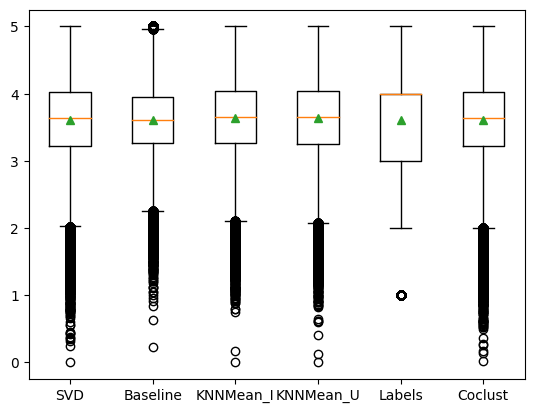

In [355]:
#printing out boxplots of errors
SVD_scores = df_SVD_pred['est'].to_list()
SVD_err = df_SVD_pred['err'].to_list()
bl_scores= df_bl_pred['est'].to_list()
bl_error= df_bl_pred['err'].to_list()
# KNNZ_scores = df_KNNZ_pred['est'].to_list() removed KNZscore from final report after adding coclustering and adding item based KNNmeans
# KNNZ_err = df_KNNZ_pred['err'].to_list()
KNNM_scores= df_KNNMean_pred['est'].to_list()
KNNM_error= df_KNNMean_pred['err'].to_list()
KNNM_I_score=df_KMeanItem_pred['est'].to_list()
KNNM_I_err=df_KMeanItem_pred['err'].to_list()
ratings= df_val['rating'].to_list()
clust_scores=df_clust_pred['est'].to_list()
clust_err=df_clust_pred['err'].to_list()
print ('Compare Rating Predictions')
names = ['SVD','Baseline','KNNMean_I','KNNMean_U','Labels','Coclust']
results = [SVD_scores,bl_scores,KNNM_I_score,KNNM_scores,ratings,clust_scores]
pyplot.boxplot(results, labels=names, showmeans=True)
#pyplot.show()
pyplot.savefig('pred_ratings')



Compare Error Rates


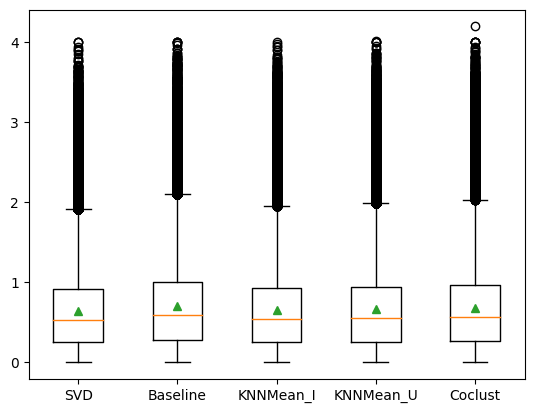

In [356]:
print ('Compare Error Rates')
names = ['SVD','Baseline','KNNMean_I','KNNMean_U','Coclust']
results = [SVD_err,bl_error,KNNM_I_err,KNNM_error,clust_err]
pyplot.boxplot(results, labels=names, showmeans=True)
#pyplot.show()
pyplot.savefig('pred_errors')

In [344]:
#printing results of all four metrics for the four tuned algorithms 
data = [["BaselineOnly",0.9,0.708,0.721,0.724],
       ["KNNMeans_User",0.859,0.67,0.738,0.718], 
        ["KNNMeans_Item", 0.849,0.661,0.721,0.724], 
        ["SVD",0.83,0.647,0.689,0.738],
       ["Coclustering",0.876,0.685,0.767,0.698]]

col_names=["Algorithm","RMSE","MAE","MSE","FCP"]

print(tabulate(data, headers=col_names, tablefmt="heavy_grid"))#showindex="always"
metrics_table=tabulate(data, headers=col_names, tablefmt="heavy_grid")
dataframe_to_image(metrics_table, filename = path)

┏━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃ Algorithm     ┃   RMSE ┃   MAE ┃   MSE ┃   FCP ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━┫
┃ BaselineOnly  ┃  0.9   ┃ 0.708 ┃ 0.721 ┃ 0.724 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━┫
┃ KNNMeans_User ┃  0.859 ┃ 0.67  ┃ 0.738 ┃ 0.718 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━┫
┃ KNNMeans_Item ┃  0.849 ┃ 0.661 ┃ 0.721 ┃ 0.724 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━┫
┃ SVD           ┃  0.83  ┃ 0.647 ┃ 0.689 ┃ 0.738 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━╋━━━━━━━╋━━━━━━━╋━━━━━━━┫
┃ Coclustering  ┃  0.876 ┃ 0.685 ┃ 0.767 ┃ 0.698 ┃
┗━━━━━━━━━━━━━━━┻━━━━━━━━┻━━━━━━━┻━━━━━━━┻━━━━━━━┛


NameError: name 'dataframe_to_image' is not defined

In [330]:
col_names=["RMSE","MAE","MSE","FCP"]

In [153]:
# Clustering parameter tuning 
def get_list(ltype):
  if ltype == 'ep':
    return [5,10,15,20,25,30]
  elif ltype == 'cu':
    return [2,4,8,16,32,64,100]
  elif ltype == 'ci':
    return [2,4,8,16,32,64,100]
  else:
    return None

def run_coc_sweep():
  # Load and initialize data
  train_file = 'netflix-5k.train.feather'
  val_file = 'netflix-5k.validation.feather'
  movie_file = 'netflix-5k.movie_titles.feather'
  train_df = feather.read_feather(train_file)
  val_df = feather.read_feather(val_file)
  movie_df = feather.read_feather(movie_file)
  reader = Reader(rating_scale=(0, 5))
  data = Dataset.load_from_df(train_df[['userID','movieID',
                                        'rating']],reader)
  datav = Dataset.load_from_df(val_df[['userID','movieID',
                                       'rating']],reader)
  trainset = data.build_full_trainset()
  NA,valset = train_test_split(datav, test_size=1.0)

  # RMSE
  all_params = { 'n_cltr_u':'cu', 'n_cltr_i':'ci', 'n_epochs':'ep'}
  print ('Sweep for best paramters for RMSE and CoClustering')
  param_grid = {}
   
  for x in range(1,5):
    for k,v in all_params.items():
      param_grid[k] = get_list(v)
      print ('Gridsearch Grid =', param_grid)
      with parallel_backend('multiprocessing', n_jobs=4):
        gs = GridSearchCV(CoClustering, param_grid, joblib_verbose=10, cv=10,
                          measures=['rmse'], n_jobs=4)
        gs.fit(data)  
      s = gs.best_score['rmse']
      p = gs.best_params['rmse']
      print('RMSE={} Grid={}'.format(round(s,3),p))
      param_grid[k] = [p[k]]
 
#   # MAE
#   all_params = { 'n_cltr_u':'cu', 'n_cltr_i':'ci', 'n_epochs':'ep'}
#   print ('Sweep for best paramters for MAE and CoClustering')
#   param_grid = {}
#   # SEE ABOVE
#   for x in range(1,5):
#    for k,v in all_params.items():
#       param_grid[k] = get_list(v)
#       print ('Gridsearch Grid =', param_grid)
#       with parallel_backend('multiprocessing', n_jobs=4):
#         gs = GridSearchCV(CoClustering, param_grid, joblib_verbose=10, cv=10,
#                           measures=['mae'], n_jobs=4)
#         gs.fit(data)  
#       s = gs.best_score['mae']
#       p = gs.best_params['mae']
#       print('MAE={} Grid={}'.format(round(s,3),p))
#       param_grid[k] = [p[k]]

run_coc_sweep()



Sweep for best paramters for RMSE and CoClustering
Gridsearch Grid = {'n_cltr_u': [2, 4, 8, 16, 32, 64, 100]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   22.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   34.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 10.2min finished


RMSE=0.883 Grid={'n_cltr_u': 100}
Gridsearch Grid = {'n_cltr_u': [100], 'n_cltr_i': [2, 4, 8, 16, 32, 64, 100]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  8.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 13.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 22.1min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 31.6min finished


RMSE=0.882 Grid={'n_cltr_u': 100, 'n_cltr_i': 4}
Gridsearch Grid = {'n_cltr_u': [100], 'n_cltr_i': [4], 'n_epochs': [5, 10, 15, 20, 25, 30]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   48.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 16.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 19.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 19.1min finished


RMSE=0.882 Grid={'n_cltr_u': 100, 'n_cltr_i': 4, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [2, 4, 8, 16, 32, 64, 100], 'n_cltr_i': [4], 'n_epochs': [20]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   32.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   54.9s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 10.0min finished


RMSE=0.881 Grid={'n_cltr_u': 64, 'n_cltr_i': 4, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [64], 'n_cltr_i': [2, 4, 8, 16, 32, 64, 100], 'n_epochs': [20]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  5.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 15.7min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 24.0min finished


RMSE=0.882 Grid={'n_cltr_u': 64, 'n_cltr_i': 4, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [64], 'n_cltr_i': [4], 'n_epochs': [5, 10, 15, 20, 25, 30]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   52.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  7.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 13.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 13.1min finished


RMSE=0.882 Grid={'n_cltr_u': 64, 'n_cltr_i': 4, 'n_epochs': 25}
Gridsearch Grid = {'n_cltr_u': [2, 4, 8, 16, 32, 64, 100], 'n_cltr_i': [4], 'n_epochs': [25]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   39.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 12.5min finished


RMSE=0.882 Grid={'n_cltr_u': 64, 'n_cltr_i': 4, 'n_epochs': 25}
Gridsearch Grid = {'n_cltr_u': [64], 'n_cltr_i': [2, 4, 8, 16, 32, 64, 100], 'n_epochs': [25]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  7.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 11.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 14.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 19.8min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 29.8min finished


RMSE=0.882 Grid={'n_cltr_u': 64, 'n_cltr_i': 8, 'n_epochs': 25}
Gridsearch Grid = {'n_cltr_u': [64], 'n_cltr_i': [8], 'n_epochs': [5, 10, 15, 20, 25, 30]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   37.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   56.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 12.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 14.7min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 14.7min finished


RMSE=0.882 Grid={'n_cltr_u': 64, 'n_cltr_i': 8, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [2, 4, 8, 16, 32, 64, 100], 'n_cltr_i': [8], 'n_epochs': [20]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 11.0min finished


RMSE=0.881 Grid={'n_cltr_u': 16, 'n_cltr_i': 8, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [16], 'n_cltr_i': [2, 4, 8, 16, 32, 64, 100], 'n_epochs': [20]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   40.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  7.0min
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed: 12.5min finished


RMSE=0.88 Grid={'n_cltr_u': 16, 'n_cltr_i': 8, 'n_epochs': 20}
Gridsearch Grid = {'n_cltr_u': [16], 'n_cltr_i': [8], 'n_epochs': [5, 10, 15, 20, 25, 30]}


[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   16.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   26.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   51.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  5.4min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  5.4min finished


RMSE=0.88 Grid={'n_cltr_u': 16, 'n_cltr_i': 8, 'n_epochs': 20}


In [291]:
#clustering using best params from above
# RMSE = 0.885 untuned
# MAE = 0.694
print ('Run coclust model')
clust = CoClustering(n_cltr_u= 16,n_cltr_i= 8,n_epochs=20)
model = clust.fit(trainset)
predictions_clust = clust.test(valset)
print('RMSE = {}'.format(round(accuracy.rmse(predictions_clust,verbose=False),3)))
print('MAE = {}'.format(round(accuracy.mae(predictions_clust,verbose=False),3)))
print('MSE = {}'.format(round(accuracy.mse(predictions_clust,verbose=False),3)))
print('FCP = {}'.format(round(accuracy.fcp(predictions_clust,verbose=False),3)))

Run coclust model
RMSE = 0.876
MAE = 0.685
MSE = 0.767
FCP = 0.698


In [292]:
#turn co-clust predictions into DF
df_clust_pred = pd.DataFrame(predictions_clust, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df_clust_pred['Iu'] = df_clust_pred.uid.apply(get_Iu)
df_clust_pred['Ui'] = df_clust_pred.iid.apply(get_Ui)
df_clust_pred['err'] = abs(df_clust_pred.est - df_clust_pred.rui)
df_clust_pred = df_clust_pred.drop(['details'],axis=1)
display(df_clust_pred)

,uid,iid,rui,est,Iu,Ui,err
0,42791,108,5.0,2.605754,179,293,2.394246
1,285668,10820,4.0,3.746239,273,1400,0.253761
2,2066572,15064,4.0,3.984878,268,415,0.015122
3,2578674,15421,3.0,3.674091,144,513,0.674091
4,516854,15788,4.0,3.320595,207,1444,0.679405
...,...,...,...,...,...,...,...
321485,708271,10176,3.0,3.957261,275,218,0.957261
321486,1225914,6386,3.0,3.171271,340,1667,0.171271
321487,2398160,2874,4.0,4.334536,346,1146,0.334536
321488,154790,442,4.0,3.657447,354,452,0.342553


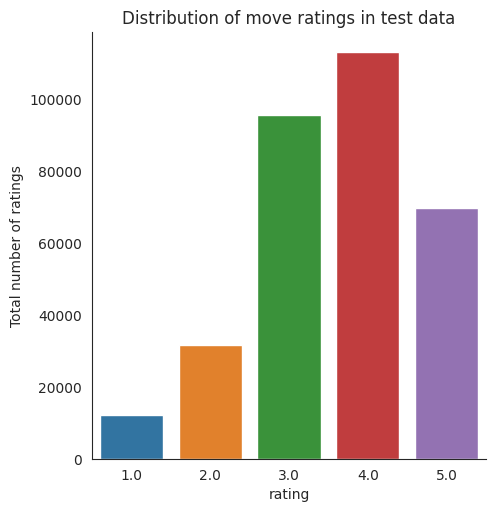

In [290]:
# Check the distribution of the ratings on test set 
with sns.axes_style('white'):
    g = sns.catplot(data=df_val, x='rating', kind='count')#title= 'Distribution of ratings for validation data'
    g.set_ylabels("Total number of ratings").set(title='Distribution of move ratings in test data')
    g.savefig('movieratingsbarplt')

In [366]:
bl10,bl_comp=top_10_per_user(df_bl_pred)
bl_comp

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,6428,4.0,4.443983,276,1039,0.443983,6428,1207,1962,1962,To Kill a Mockingbird,Drama
1,785,2862,4.0,4.413431,276,2131,0.413431,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
2,785,3864,5.0,4.385976,276,795,0.614024,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
3,785,16377,4.0,4.375172,276,2128,0.375172,16377,3147,1999,1999,The Green Mile,Crime|Drama
4,785,6029,3.0,4.315321,276,1198,1.315321,6029,4973,2001,2001,Amelie,Comedy|Romance
5,785,12721,4.0,4.303837,276,66,0.303837,12721,6669,1952,1952,Ikiru,Drama
6,785,15997,2.0,4.271854,276,421,2.271854,15997,1945,1954,1954,On the Waterfront,Crime|Drama
7,785,13614,5.0,4.245253,276,1451,0.754747,13614,2502,1999,1999,Office Space,Comedy|Crime
8,785,16872,2.0,4.206644,276,915,2.206644,16872,553,1993,1993,Tombstone,Action|Drama|Western
9,785,7166,3.0,4.193636,276,216,1.193636,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy


In [369]:
SVD10,SVD_comp=top_10_per_user(df_SVD_pred)
SVD_comp

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,3864,5.0,4.799685,276,795,0.200315,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
1,785,7166,3.0,4.613906,276,216,1.613906,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy
2,785,6720,3.0,4.550846,276,1275,1.550846,6720,5010,2001,2001,Black Hawk Down,Action|Drama|War
3,785,8806,5.0,4.496477,276,752,0.503523,8806,1201,1966,1966,"The Good, the Bad and the Ugly",Action|Adventure|Western
4,785,13614,5.0,4.401012,276,1451,0.598988,13614,2502,1999,1999,Office Space,Comedy|Crime
5,785,17472,4.0,4.358073,276,215,0.358073,17472,3682,1973,1973,Magnum Force,Action|Crime|Drama|Thriller
6,785,2862,4.0,4.342224,276,2131,0.342224,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
7,785,16377,4.0,4.269765,276,2128,0.269765,16377,3147,1999,1999,The Green Mile,Crime|Drama
8,785,16872,2.0,4.225611,276,915,2.225611,16872,553,1993,1993,Tombstone,Action|Drama|Western
9,785,16272,4.0,4.190203,276,1417,0.190203,16272,3996,2000,2000,"Crouching Tiger, Hidden Dragon",Action|Drama|Romance


In [370]:
KN_I_10,KN_I_comp=top_10_per_user(df_KMeanItem_pred)
KN_I_comp

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,3864,5.0,4.661839,276,795,0.338161,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
1,785,2862,4.0,4.522084,276,2131,0.522084,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
2,785,6720,3.0,4.495007,276,1275,1.495007,6720,5010,2001,2001,Black Hawk Down,Action|Drama|War
3,785,7166,3.0,4.449795,276,216,1.449795,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy
4,785,16377,4.0,4.416571,276,2128,0.416571,16377,3147,1999,1999,The Green Mile,Crime|Drama
5,785,16872,2.0,4.346806,276,915,2.346806,16872,553,1993,1993,Tombstone,Action|Drama|Western
6,785,13614,5.0,4.320027,276,1451,0.679973,13614,2502,1999,1999,Office Space,Comedy|Crime
7,785,8806,5.0,4.284561,276,752,0.715439,8806,1201,1966,1966,"The Good, the Bad and the Ugly",Action|Adventure|Western
8,785,6029,3.0,4.277050,276,1198,1.277050,6029,4973,2001,2001,Amelie,Comedy|Romance
9,785,191,5.0,4.247711,276,1570,0.752289,191,6333,2003,2003,X2: X-Men United,Action|Adventure|Sci-Fi|Thriller


In [372]:
KN_U_10,KN_U_comp=top_10_per_user(df_KNNMean_pred)
KN_U_comp

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,3864,5.0,4.497457,276,795,0.502543,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
1,785,13614,5.0,4.360095,276,1451,0.639905,13614,2502,1999,1999,Office Space,Comedy|Crime
2,785,7166,3.0,4.334454,276,216,1.334454,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy
3,785,16377,4.0,4.294542,276,2128,0.294542,16377,3147,1999,1999,The Green Mile,Crime|Drama
4,785,16872,2.0,4.279300,276,915,2.279300,16872,553,1993,1993,Tombstone,Action|Drama|Western
5,785,8806,5.0,4.257489,276,752,0.742511,8806,1201,1966,1966,"The Good, the Bad and the Ugly",Action|Adventure|Western
6,785,6029,3.0,4.250025,276,1198,1.250025,6029,4973,2001,2001,Amelie,Comedy|Romance
7,785,2862,4.0,4.243641,276,2131,0.243641,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
8,785,6720,3.0,4.242331,276,1275,1.242331,6720,5010,2001,2001,Black Hawk Down,Action|Drama|War
9,785,1770,5.0,4.230087,276,411,0.769913,1770,778,1996,1995,Trainspotting,Comedy|Crime|Drama


In [373]:
clust10,clust_comp=top_10_per_user(df_clust_pred)
clust_comp

,uid,iid,rui,est,Iu,Ui,err,movieID,imdb_id,imdb_date,date,title,genre
0,785,2862,4.0,4.556830,276,2131,0.556830,2862,593,1991,1991,The Silence of the Lambs,Crime|Horror|Thriller
1,785,3864,5.0,4.506039,276,795,0.493961,3864,33794,2005,2005,Batman Begins,Action|Crime|IMAX
2,785,13614,5.0,4.498216,276,1451,0.501784,13614,2502,1999,1999,Office Space,Comedy|Crime
3,785,16377,4.0,4.423958,276,2128,0.423958,16377,3147,1999,1999,The Green Mile,Crime|Drama
4,785,7166,3.0,4.411094,276,216,1.411094,7166,178613,2000,2000,Dave Chappelle: Killin' Them Softly,Comedy
5,785,8806,5.0,4.294910,276,752,0.705090,8806,1201,1966,1966,"The Good, the Bad and the Ugly",Action|Adventure|Western
6,785,6428,4.0,4.241547,276,1039,0.241547,6428,1207,1962,1962,To Kill a Mockingbird,Drama
7,785,16872,2.0,4.231883,276,915,2.231883,16872,553,1993,1993,Tombstone,Action|Drama|Western
8,785,6029,3.0,4.203060,276,1198,1.203060,6029,4973,2001,2001,Amelie,Comedy|Romance
9,785,12721,4.0,4.201568,276,66,0.201568,12721,6669,1952,1952,Ikiru,Drama
